# Tutorial：2
- 使用フレームワーク : deap
- 選択手法 : NSGA-Ⅱ
- 設計変数 : 2個
  - 連続値 : 1個
  - 離散値 : 1個
- 目的変数 : 2個
- 制約条件 : 2パターン
     1. 連続値のmin,max 
     2. 離散値の取り得るパターン

## 習得してもらうこと
- 設計変数が離散値である時の扱い方
- 制約条件が離散値を取り得るパターンの場合の扱い方

## 実施内容
 - Part0. 取り扱う問題設定

 - Patr1: モジュールのimport 

 - Part2: 評価関数の作成
   - 目的関数の設計
   - ペナルティ関数の導入


 - Part3: 遺伝的アルゴリズムの設計
   - 遺伝的アルゴリズムにおける個体の表現
   - 遺伝子操作関数の設定
     - 交叉
     - 突然変異
   - 解の選択手法の設定


 - Part4: 最適化計算の実行
   - 初期状態の設定
   - 遺伝的最適化計算の実行  


 - Part5. 結果の確認
   - 初期世代と最終世代の目的関数の値を確認
   
 - Appendix
   - 離散値が2~3変数以上存在する時におススメする、deap公式の突然変異の関数

# Part0. 取り扱う問題設定
- STEP01と同じ問題設定だが、設定変数Bを連続値から離散値に変更した

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 \\
&s.t.& 0& \leqq A \leqq 5 \\
&  &B &\in \{0, 1, 2, 3\}
\end{align*}
$


# Part1. モジュールのimport

In [1]:
%load_ext lab_black

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from deap import base, creator, tools
from deap.benchmarks.tools import hypervolume

# Part2. 評価関数の作成

### 目的関数

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2
\end{align*}
$

In [3]:
# 評価関数
def objectfunction(individual):
    """
    individual(list): 個体の設計変数を格納するlist
    """

    # 教材用として、A, Bの変数を作成
    A = individual[0]
    B = individual[1]

    f1 = 4 * A ** 2 + 4 * B ** 2
    f2 = (A - 5) ** 2 + (B - 5) ** 2
    return f1, f2

### ペナルティ関数
##### 取り得るパターンに対応した制約条件に変更しています

$ 
\begin{align*}
&s.t.& 0& \leqq A \leqq 5 \\
&  &B &\in \{0, 1, 2, 3\}
\end{align*}
$

In [4]:
# ペナルティ関数で判定したい制約条件のリスト
# 教材用にこちらで定義していますが。後ほど登場する「generator_config」から作れるようにした方が良いです
cases = [
    {
        "type": "minmax",
        "case": {0: {"min": 0, "max": 5}},
    },
    {
        "type": "pattern",
        "case": {1: [0, 1, 2, 3]},
    },
]

#### 取り得るパターンの条件に対応するために、judgepatternという関数を追加しています

In [5]:
# ペナルティ関数で使用する関数
# 連続値の範囲制約
def judgeminmax(individual, case):
    for k, v in case.items():
        if not float(v["min"]) <= individual[int(k)] <= v["max"]:
            return False
    return True


# 離散値の取り得るパターン制約
def judgepattern(individual, case):
    for k, v in case.items():
        if individual[int(k)] not in v:
            return False
    return True


# ペナルティ関数用の条件判定関数 - 他の条件が出来た時にfor文内に追記することで対応可
def judge(individual, cases):
    """
    individual(list): 個体の設計変数を格納するlist
    cases(list): 判定したい条件のlist. 各条件はdict型
    """

    for case in cases:
        if case["type"] == "pattern":
            if not judgepattern(individual, case["case"]):
                return False
        if case["type"] == "minmax":
            if not judgeminmax(individual, case["case"]):
                return False
    return True

### 評価関数&ペナルティ関数の導入

In [6]:
# ペナルティ関数の罰則値(適応度)
distance = (1000, 1000)

# 評価関数を作成
toolbox = base.Toolbox()
toolbox.register("evaluate", objectfunction)
toolbox.register("feasible", judge, cases=cases)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, delta=distance))

# Part.3 遺伝的アルゴリズムの設計


## 遺伝的アルゴリズムにおける個体の表現

In [7]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

### 制約条件を満たした初期値設定

$ 
\begin{align*}
&s.t.& 0& \leqq A \leqq 5 \\
&  &B &\in \{0, 1, 2, 3\}
\end{align*}
$

#### ※ 離散値の情報を追加しています

In [8]:
# 個体を作成する制約条件を記載したのdictを作成
generator_config = {
    # 使用するカラム
    "columns": ["A", "B"],
    # 各連続値の作成条件
    "variables": {
        "A": {"type": "real", "values": {"min": 0, "max": 5}},
        "B": {"type": "discrete", "values": [0, 1, 2, 3]},
    },
    # 突然変異で使うカラムの指定
    "mutate_real_col": ["A", "B"],
    # 連続値のカラム
    "independent_real_col": ["A"],
    # 離散値のカラム
    "independent_discrete_col": ["B"],
}

### 初期サンプルの生成関数

##### generator_configから、初期値を生成

In [9]:
# 個体を生成する関数
def generator(generator_config):
    """
    generator_config (dict): 個体を作成する制約条件が記載されたdict
    """

    var = generator_config["variables"]
    # 連続値と離散値のサンプルを生成する.
    variables = {
        k: random.uniform(v["values"]["min"], v["values"]["max"])
        if v["type"] == "real"
        else random.choice(v["values"])
        for k, v in var.items()
    }

    return [variables[col] for col in generator_config["columns"]]


# [お試し]このように作成されます
# generator(generator_config)

#### 進化計算で使用する個体の初期サンプルを、制約条件を満たすようにランダムに生成

In [10]:
toolbox.register("generator", generator, generator_config)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 遺伝子操作関数

#### 進化計算で重要な役割を持つ遺伝子操作を行う関数を生成

- deap公式の交叉・突然変異の関数を使う

### 交叉

1. 交叉関数 : `cxTwoPoint` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint)　[github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/crossover.py#L37)

In [11]:
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

### 突然変異

2. 変異関数 : `mutPolynomialBounded` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded)　[github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/mutation.py#L51)

#### 各設計変数ごとに突然変異が適応できる用にする関数
- 離散値の部分を追加しています
- 離散値のカラム、そのindexと値を`muconfig関数`で取得

In [12]:
# 突然変異用のdict作成する関数
def muconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """

    cols = constrain_dict["columns"]  # 現状のカラム
    variables = constrain_dict["variables"]  # min-max等、その変数の取れる値

    mur = constrain_dict["mutate_real_col"]  # 突然変異するカラム
    cxr = constrain_dict["independent_real_col"]  # 連続値のカラム
    mud = constrain_dict["independent_discrete_col"]  # 離散値のカラム

    mu_real_index = [cols.index(c) for c in cxr if c in cols if c in mur]  # 連続値のindex
    mu_discrete_index = [
        cols.index(c) for c in mud if c in cols if c in mur
    ]  # 離散値のindex

    # 離散値のユニーク値を取得
    mu_discrete_values = [variables[c]["values"] for c in mud if c in cols]

    mu_low = [
        constrain_dict["variables"][col]["values"]["min"] for col in cxr if col in mur
    ]  # 連続値の下限

    mu_up = [
        constrain_dict["variables"][col]["values"]["max"] for col in cxr if col in mur
    ]  # 連続値の上限

    for mi, ma in zip(mu_low, mu_up):  # 上限と下限が逆転していないか？イコールになっていないか？
        if not mi <= ma:
            raise MutateionError("some low values higher than ups values")

    mucfg = {}
    mucfg["real_indexs"] = mu_real_index  # 連続値に対する設計変数のindex
    mucfg["lows"] = mu_low  # 連続値に対する設計変数の最小値
    mucfg["ups"] = mu_up  # 連続値に対する設計変数の最大値
    mucfg["discrete_indexs"] = mu_discrete_index  # 離散値・ダミー変数に対する変異を行う設計変数のindex
    mucfg["discrete_values"] = mu_discrete_values  # 離散値・ダミー変数に対する変異を行う設計変数の取りうる値

    return mucfg

In [13]:
# 突然変異用のdice作成
mucfg = muconfig(generator_config)
mucfg

{'real_indexs': [0],
 'lows': [0],
 'ups': [5],
 'discrete_indexs': [1],
 'discrete_values': [[0, 1, 2, 3]]}

#### 以下の関数も離散値に対応できるように修正

In [14]:
# 各変数ごとに分けて突然変異をするための関数
def mutation(
    individual,
    realmut,
    real_indexs,
    discrete_indexs,
    discrete_values,
    lows,
    ups,
    indpb=None,
):
    """
    individual (list): 個体のlist
    realmut(function): 親個体, lows, ups, indpbを引数にとる変異関数
    real_index(list): 設計変数の連続値のindexのlist
    discrete_indexs(list): 設計変数の独立な離散値のindexのlist
    discrete_values(list): dicrete_indexsで指定した各離散値の取る値のlistのlist
    lows (list): 連続値の最小値
    ups(list) : 連続値の最大値
    indpb(float): 各変数に対して変異を行うか否かの確率、デフォルト値はNone. 0 <= indpb <= 1.
    """

    if not isinstance(real_indexs, list):
        raise CrossoverError(
            f'argment "real_indexs" must be list but inputed {type(real_indexs)}'
        )

    if not isinstance(discrete_indexs, list):
        raise MutateionError(
            'argment "real_indexs" must be list but inputed' f" {type(discrete_indexs)}"
        )

    if len(set(real_indexs) & set(discrete_indexs)) > 0:
        raise MutateionError(
            "The continuous value index and the dummy value index" " are duplicated."
        )

    if not isinstance(lows, list):
        raise MutateionError(f"argment lows must be  list but {type(lows)}")
    if not isinstance(ups, list):
        raise MutateionError(f"argment ups must be  list but {type(ups)}")

    if not (len(real_indexs) == len(lows) and len(real_indexs) == len(ups)):
        raise MutateionError("not match lows, ups ,or real_indexs length")

    if indpb is None:
        indpb = 1 / (len(real_indexs) + len(discrete_indexs))

    # 連続値の染色体を抽出
    real_chromosome = [individual[i] for i in real_indexs]
    # 変異を実施
    real_chromosome = realmut(real_chromosome, low=lows, up=ups, indpb=indpb)[0]
    for i, r in zip(real_indexs, real_chromosome):
        individual[i] = r

    # 離散値の染色体を抽出
    discrete_chromosome = [individual[i] for i in discrete_indexs]
    # 変異を実施
    discrete_chromosome = muchoice(discrete_chromosome, discrete_values, indpb=indpb)[0]
    # 染色体の書き換え
    for i, d in zip(discrete_indexs, discrete_chromosome):
        individual[i] = d

    return (individual,)

### 突然変異で離散値を扱う場合
- 離散値が１変数のみの場合、deap公式の関数に対応している関数が存在しなかった為、自作関数で対応する
- その変数の取り得るパターンの中から、ランダムで選ぶ
- 2~3変数以上の場合、Appendixにある関数を使って見てください

In [15]:
# 離散値が突然変異に対応するための関数
def muchoice(individual, patterns, indpb):
    """
    individual(list):有限パターンの変数を持つlist
    patterns(list):変数ごと取りうるユニークな値を格納
    indpb(float):変異確率
    """

    for (
        i,
        comb,
    ) in enumerate(patterns):
        if random.random() < indpb:
            individual[i] = random.choice(comb)

    return (individual,)

In [16]:
# deapにある突然変異関数を用意
realmut = partial(tools.mutPolynomialBounded, eta=20)

# 突然変異を行う関数"mutate"を登録
toolbox.register("mutate", mutation, realmut=realmut, **mucfg)

## 解の選択（世代交代）手法

#### 親個体と生成した子個体の中から良い個体を残し、悪い個体を淘汰します
#### 今回も、NSGAⅡの選択手法を用います

- [selNSGA2について_deap公式](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA2)
- [selNSGA2の動作ついて_github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/emo.py#L15)

In [17]:
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA2)

# Part.4 最適化計算の実行

#### 初期状態の設定

- 初期サンプル（第一世代）の生成
- 適合度割当

In [18]:
random.seed(1)

NGEN = 300  # 繰り返し世代数
MU = 100  # 集団内の個体数
CXPB = 0.9  # 交叉率
MUTPB = 1  # 変異率

# 第一世代の生成
pop = toolbox.population(n=MU)
pop_init = pop[:]

invalid_ind = []
for ind in pop:
    if not ind.fitness.valid:
        invalid_ind.append(ind)

fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
pop = toolbox.select(pop, len(pop))

#### 最適計算の実行

In [19]:
# 最適計算の実行
for gen in range(1, NGEN):
    # 子母集団生成
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    # 交叉と突然変異
    ## 偶数番目と奇数番目の個体を取り出し交叉
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        # 交叉させる個体を厳選
        if random.random() <= CXPB:
            # 交叉
            toolbox.mate(ind1, ind2)

        # 突然変異
        if random.random() <= MUTPB:
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)

        # 交叉と突然変異させた個体は適応度を削除する
        del ind1.fitness.values, ind2.fitness.values

    # 適応度を削除した個体について適応度の再評価を行う
    invalid_ind = []
    for ind in offspring:
        if not ind.fitness.valid:
            invalid_ind.append(ind)

    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # 次世代を選択
    pop = toolbox.select(pop + offspring, MU)

# Part5. 結果の確認

## 初期世代と最終世代の目的関数の値を確認

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2
\end{align*}
$

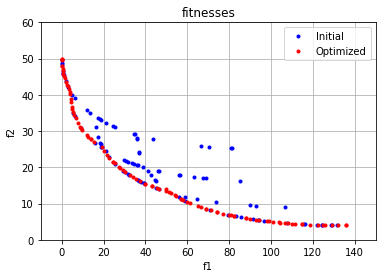

In [20]:
# 目的関数の値を確認
fitnesses_init = np.array(
    [list(pop_init[i].fitness.values) for i in range(len(pop_init))]
)
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
# グラフで確認
plt.plot(fitnesses_init[:, 0], fitnesses_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(fitnesses[:, 0], fitnesses[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("fitnesses")
# 初期の例外値が残っているのでグラフ範囲を指定
plt.xlim(-10, 150)
plt.ylim(0, 60)
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)

### ハイパーボリューム

In [21]:
# 最終世代のハイパーボリュームを出力
print("Final population hypervolume is %f" % hypervolume(pop, [200.0, 100.0]))

Final population hypervolume is 17970.922876


# Appendix
### 離散値が2~3変数以上存在する場合、以下のdeap公式の突然変異関数が使える

#### 遺伝子の中から、シャッフルをして突然変異を行う
##### 注意
- 離散値と連続を分けてシャッフルを行うこと
- シャッフルをした際に、離散値の取り得るパターン外同士でシャッフルを行う場合がある

In [22]:
def mutShuffleIndexes(individual, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]

    return (individual,)


mutShuffleIndexes([0, 2, 3, 4], 0.5)

([3, 2, 4, 0],)

#### 遺伝子のbit反転して突然変異を行う
- ダミー変数など、0,1しかない変数に有効

In [23]:
def mutFlipBit(individual, indpb):
    """Flip the value of the attributes of the input individual and return the
    mutant. The *individual* is expected to be a :term:`sequence` and the values of the
    attributes shall stay valid after the ``not`` operator is called on them.
    The *indpb* argument is the probability of each attribute to be
    flipped. This mutation is usually applied on boolean individuals.
    :param individual: Individual to be mutated.
    :param indpb: Independent probability for each attribute to be flipped.
    :returns: A tuple of one individual.
    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = type(individual[i])(not individual[i])

    return (individual,)


mutFlipBit([0, 0, 0, 1, 1], 0.6)

([0, 0, 1, 0, 1],)